### Import and Read The Data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sns.set_theme(style="darkgrid", font_scale=1, rc={"axes.titlesize":18})

In [5]:
df = pd.read_csv("../data/external/Mall_Customers.csv")

In [6]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.shape

(200, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### EDA

In [10]:
df.drop("CustomerID", axis=1, inplace=True)

In [11]:
df_numeric = df.select_dtypes(include="int64")

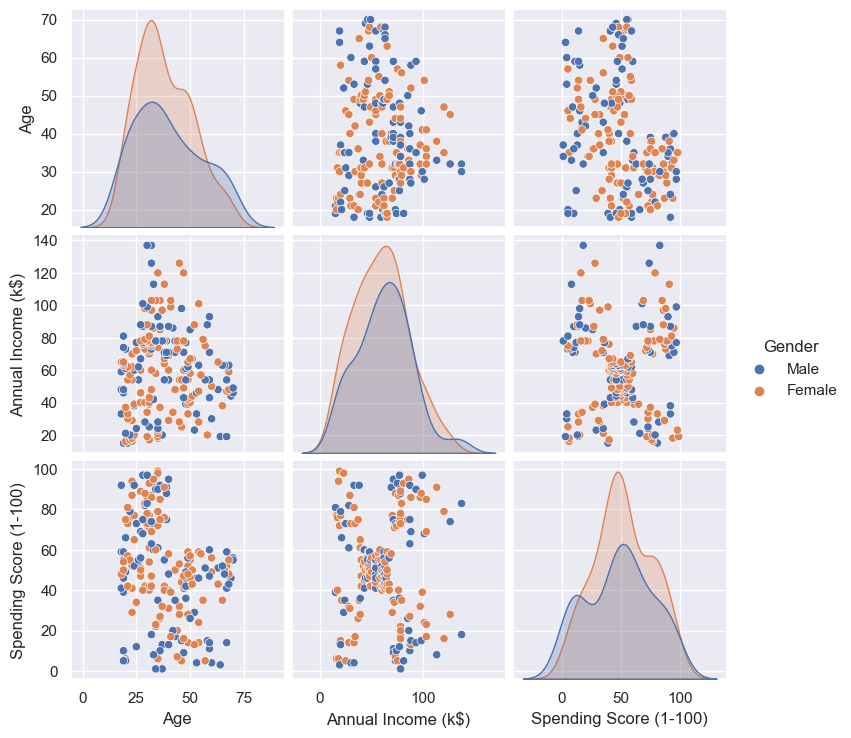

In [12]:
sns.pairplot(data=df, hue="Gender")

based on pairplot above we can only see clearly if "Annual Income" vs "Spending Score" makes a cluster in their scatter plot

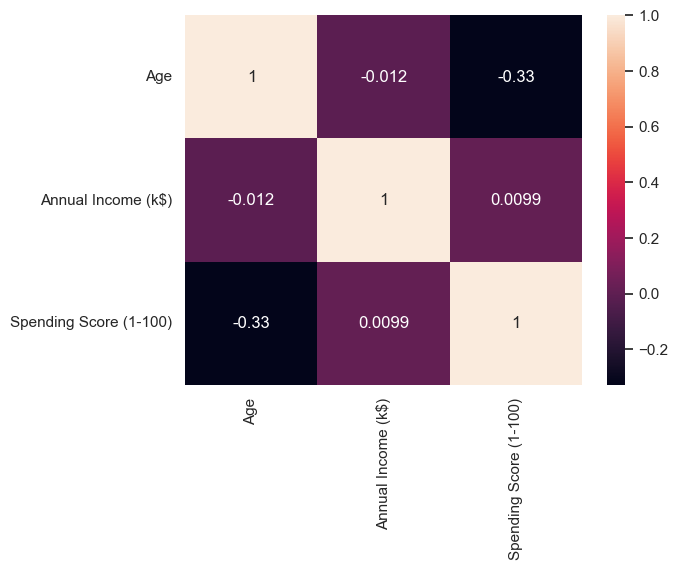

In [13]:
sns.heatmap(df_numeric.corr(), annot= True)
plt.show()

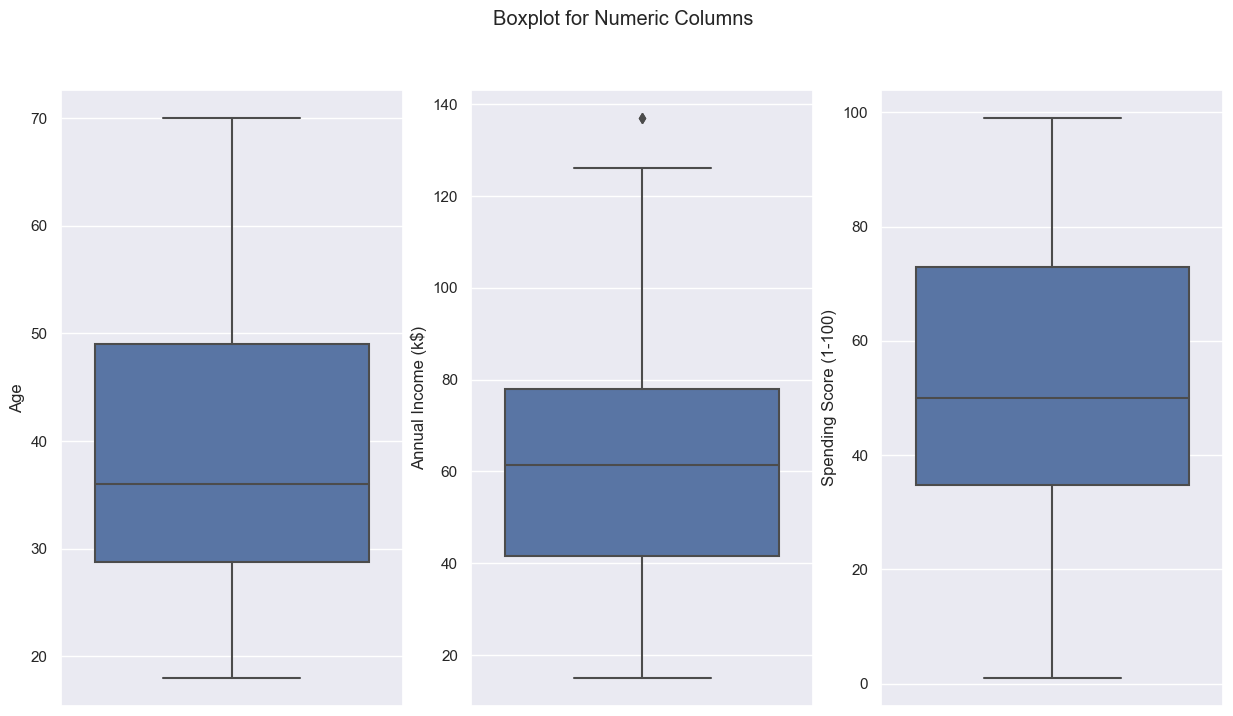

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(df_numeric.columns), figsize = (15,8))

for i,column in enumerate(df_numeric.columns):
    sns.boxplot(data=df, y=column, ax=ax[i])

plt.suptitle("Boxplot for Numeric Columns")
plt.show()

In [15]:
def add_values_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()+p.get_width()/2.,p.get_height()), ha = "center", va="center", xytext=(0,5), fontsize=12, color="black",textcoords='offset points')

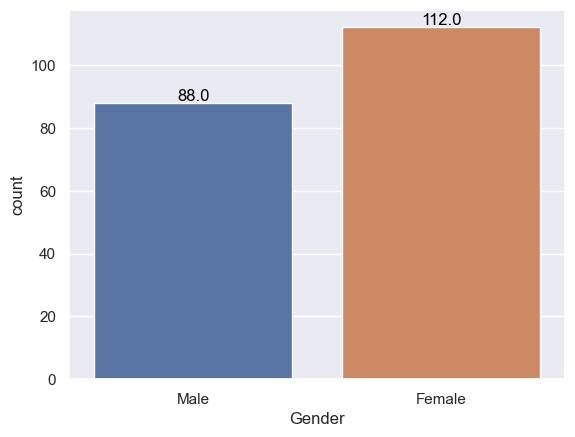

In [16]:
ax = sns.countplot(data = df, x="Gender")
add_values_labels(ax)

plt.show()

### 

### Data Cleaning

we remove the outlier especially in Annual Income columns based the distribution plot before

In [17]:
q1 = df_numeric["Annual Income (k$)"].quantile(0.25)
q3 = df_numeric["Annual Income (k$)"].quantile(0.75)

iqr = q3 - q1
upper_bound = q3 + 1.5*iqr

df_numeric_cleaned = df_numeric[df_numeric["Annual Income (k$)"]<=upper_bound]


In [36]:
df_numeric_cleaned.shape

(198, 3)

Total data is from 200 to 198 data

### Modelling

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [19]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric_cleaned)

### Clustering Age vs Annual Income

In [20]:
inertias = []

for i in range(1,8):
    km = KMeans(n_clusters=i)
    km.fit(df_scaled[:,:2])
    inertias.append(km.inertia_)

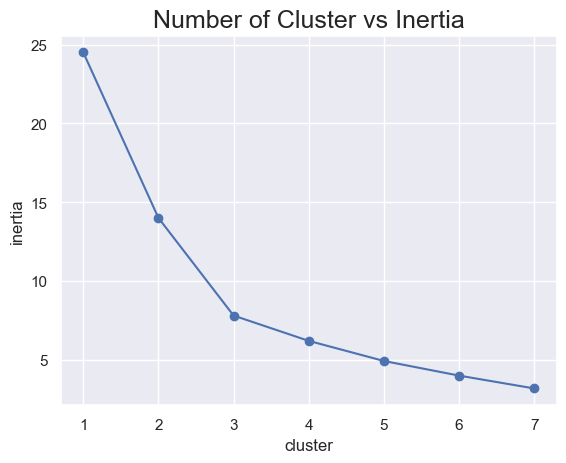

In [21]:
plt.plot(range(1,8),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

In [22]:
km = KMeans(n_clusters=3)
km.fit(df_scaled[:,:2])

KMeans(n_clusters=3)

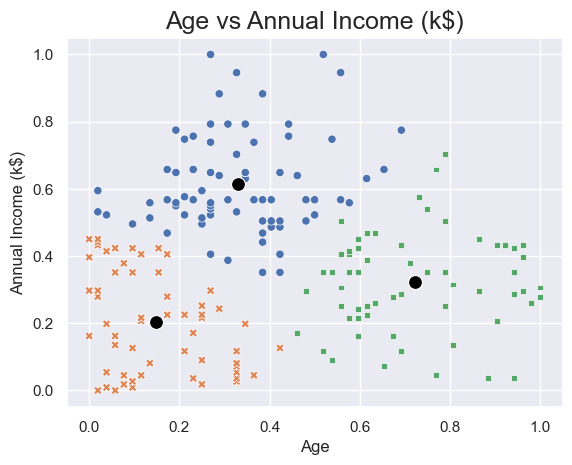

In [23]:
centroids = km.cluster_centers_
label = km.labels_

sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Age vs Annual Income (k$)")
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")

plt.show()

### Age vs Spending Score (1-100)

In [24]:
inertias = []

for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(df_scaled[:,[0,2]])
    inertias.append(km.inertia_)

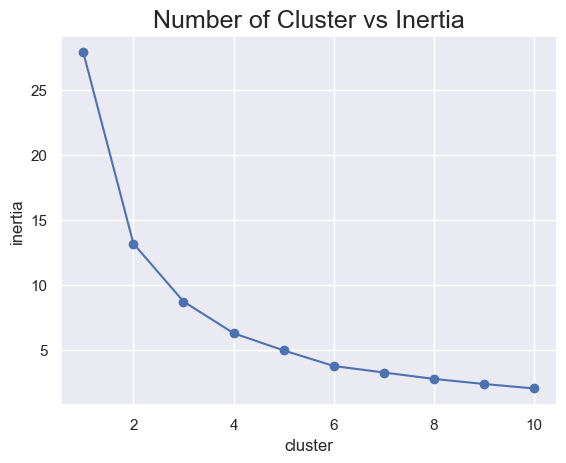

In [25]:
plt.plot(range(1,11),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

In [26]:
km = KMeans(n_clusters=4)
km.fit(df_scaled[:,[0,2]])

KMeans(n_clusters=4)

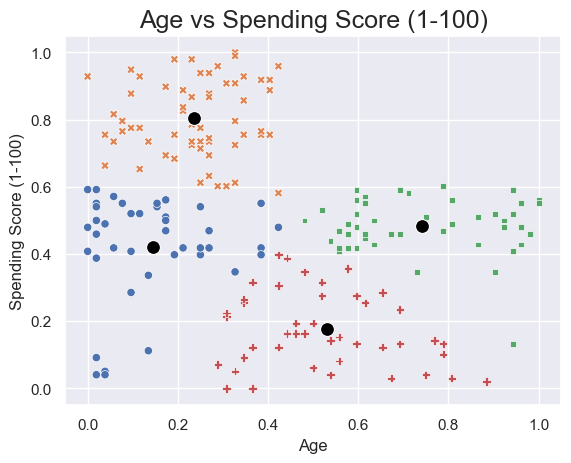

In [27]:
centroids = km.cluster_centers_
label = km.labels_

sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,2], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Age vs Spending Score (1-100)")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")

plt.show()

### Annual Income vs Spending Score (1-100)

In [28]:
inertias = []

for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(df_scaled[:,[1,2]])
    inertias.append(km.inertia_)

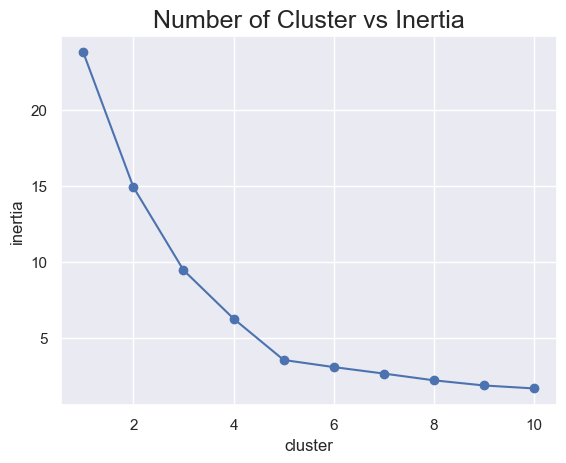

In [29]:
plt.plot(range(1,11),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

In [30]:
km = KMeans(n_clusters=5)
km.fit(df_scaled[:,[1,2]])

KMeans(n_clusters=5)

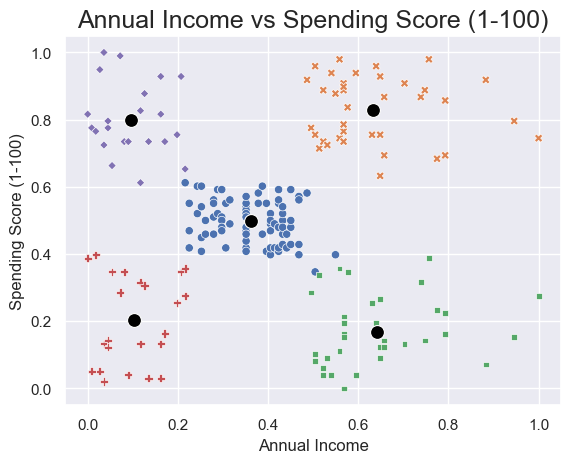

In [31]:
centroids = km.cluster_centers_
label = km.labels_

sns.scatterplot(x=df_scaled[:,1], y=df_scaled[:,2], hue=label, legend=False, style=label, palette="deep")
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], s = 100, c="black")
plt.title("Annual Income vs Spending Score (1-100)")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score (1-100)")

plt.show()

### All the feature numeric

In [32]:
inertias = []

for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(df_scaled)
    inertias.append(km.inertia_)

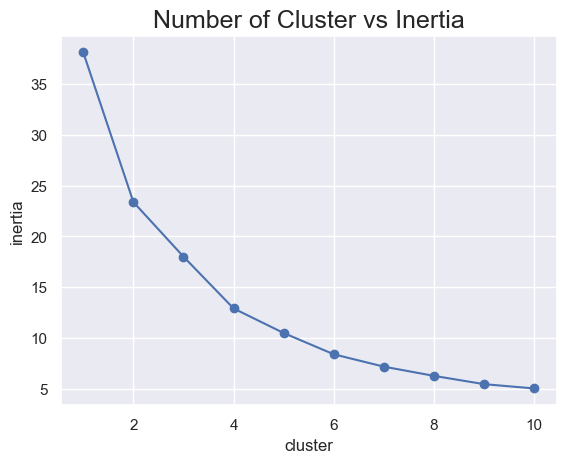

In [33]:
plt.plot(range(1,11),inertias, marker="o")

plt.title("Number of Cluster vs Inertia")
plt.xlabel("cluster")
plt.ylabel("inertia")

plt.show()

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


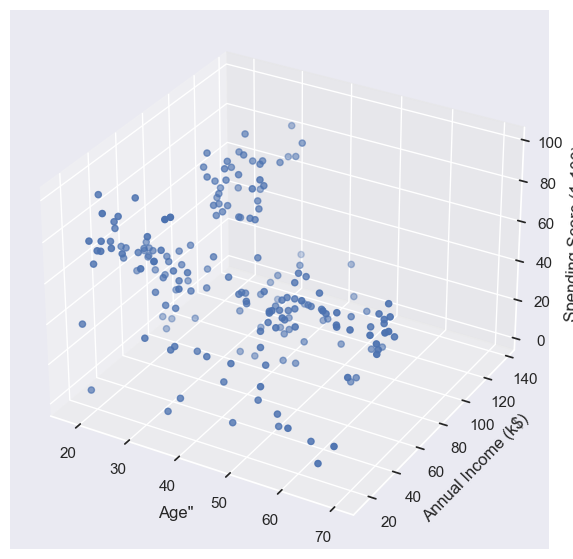

In [34]:
plt.figure(figsize=(15,7))
axes = plt.axes(projection="3d")
print(type(axes))
axes.scatter3D(df_numeric["Age"],df_numeric["Annual Income (k$)"],df_numeric["Spending Score (1-100)"])

axes.set_xlabel('Age"')
axes.set_ylabel('Annual Income (k$)')
axes.set_zlabel('Spending Score (1-100)')

plt.show()

#### Silhoutte Analysis

because we cannot see the elbow point clearly then we will try to use silhoutte analysis

For n_clusters = 3 The average silhouette_score is : 0.3839349967742105
For n_clusters = 4 The average silhouette_score is : 0.3923692568421039
For n_clusters = 5 The average silhouette_score is : 0.4267871584374444
For n_clusters = 6 The average silhouette_score is : 0.4523443947724053
For n_clusters = 7 The average silhouette_score is : 0.44777493434014515
For n_clusters = 8 The average silhouette_score is : 0.39669072433995695


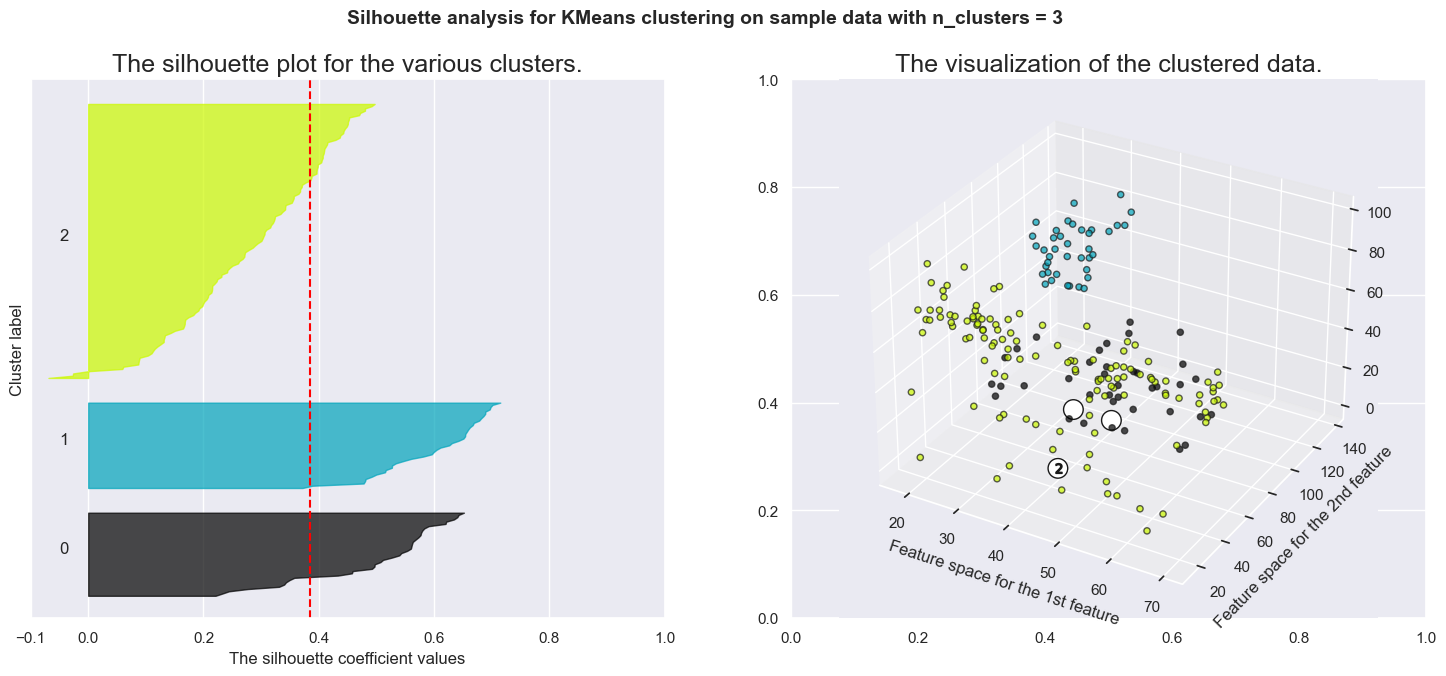

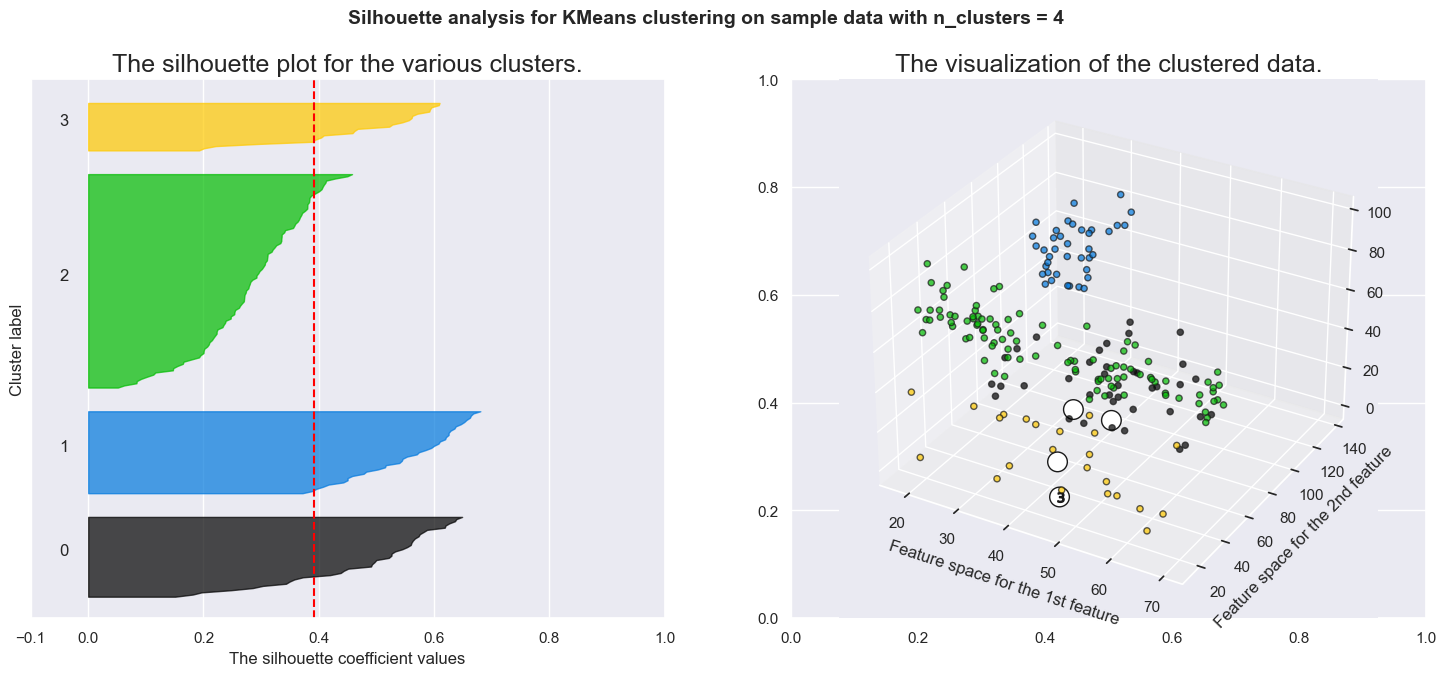

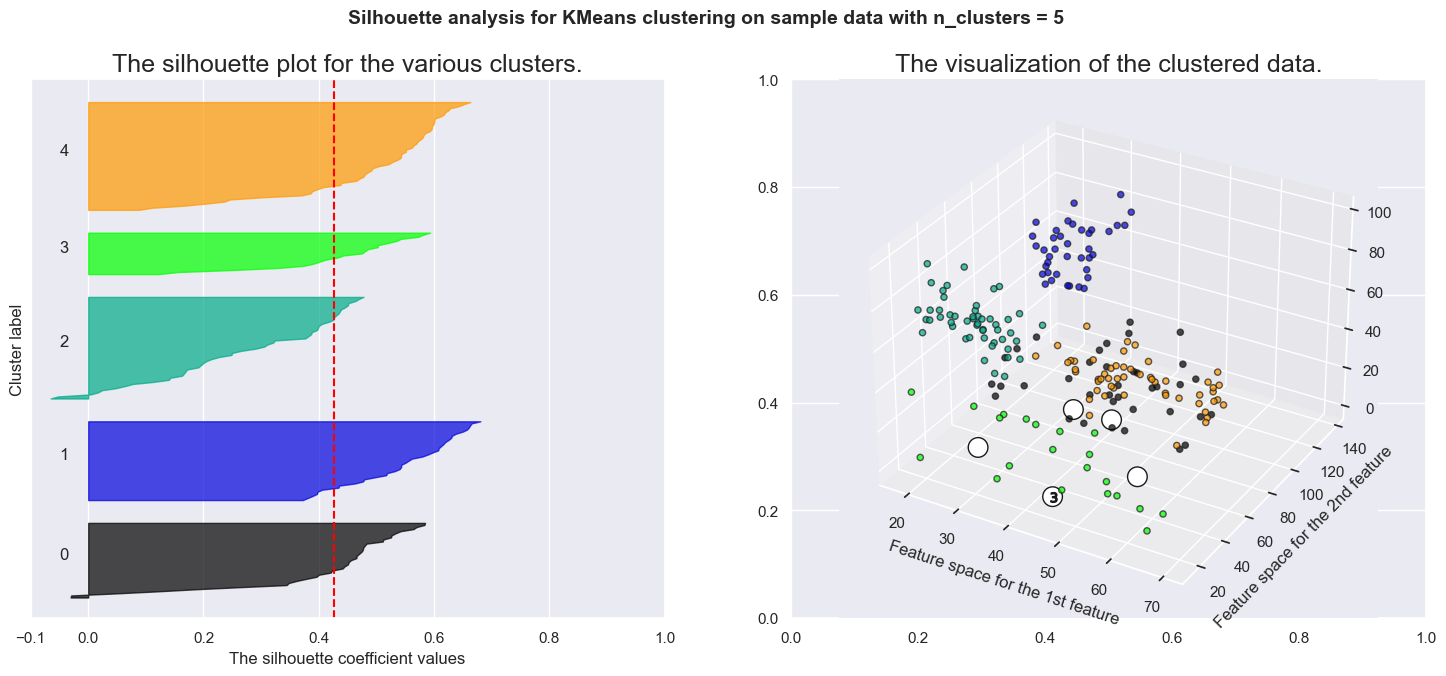

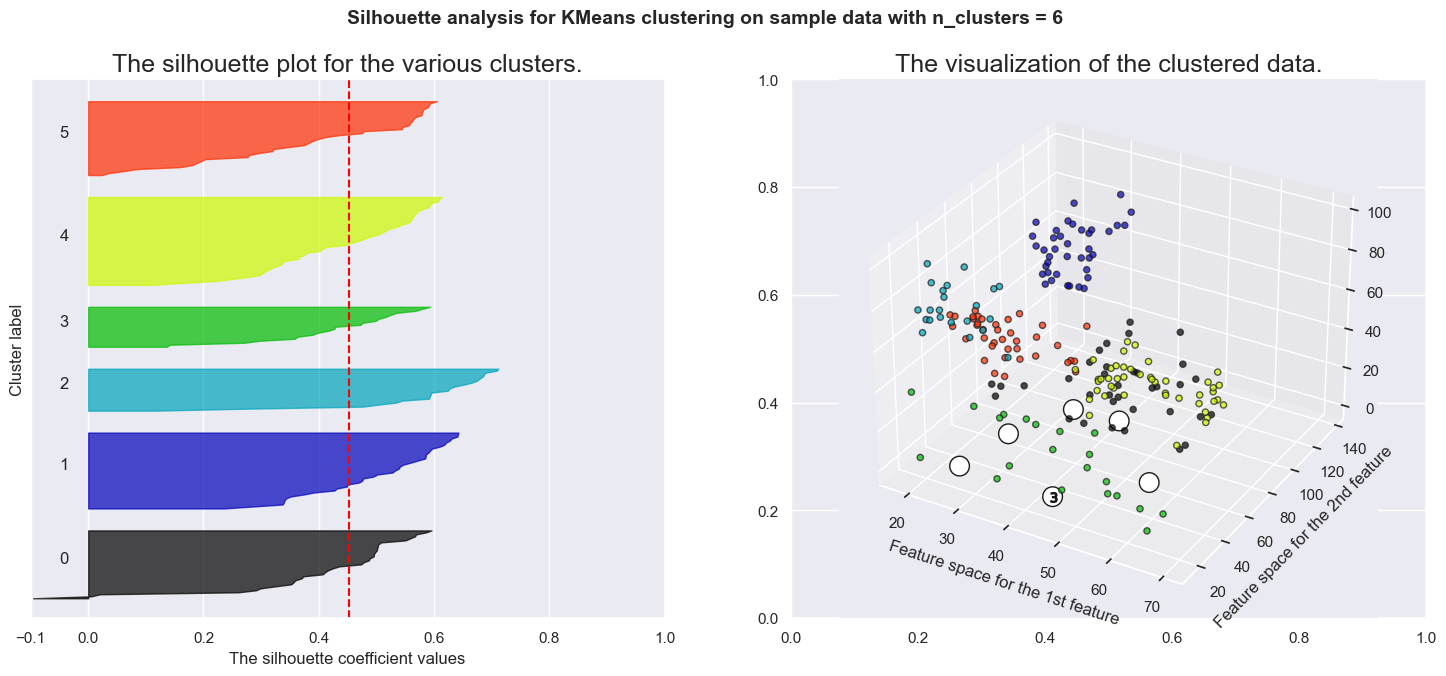

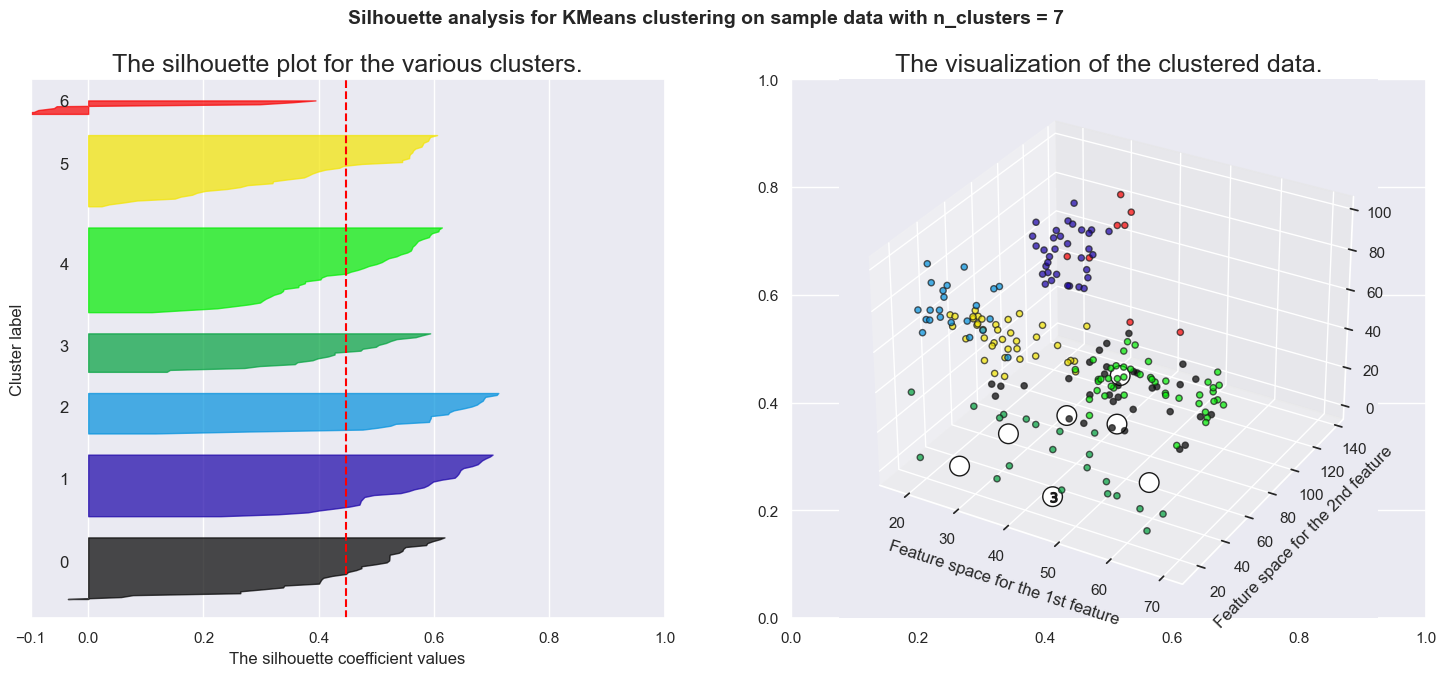

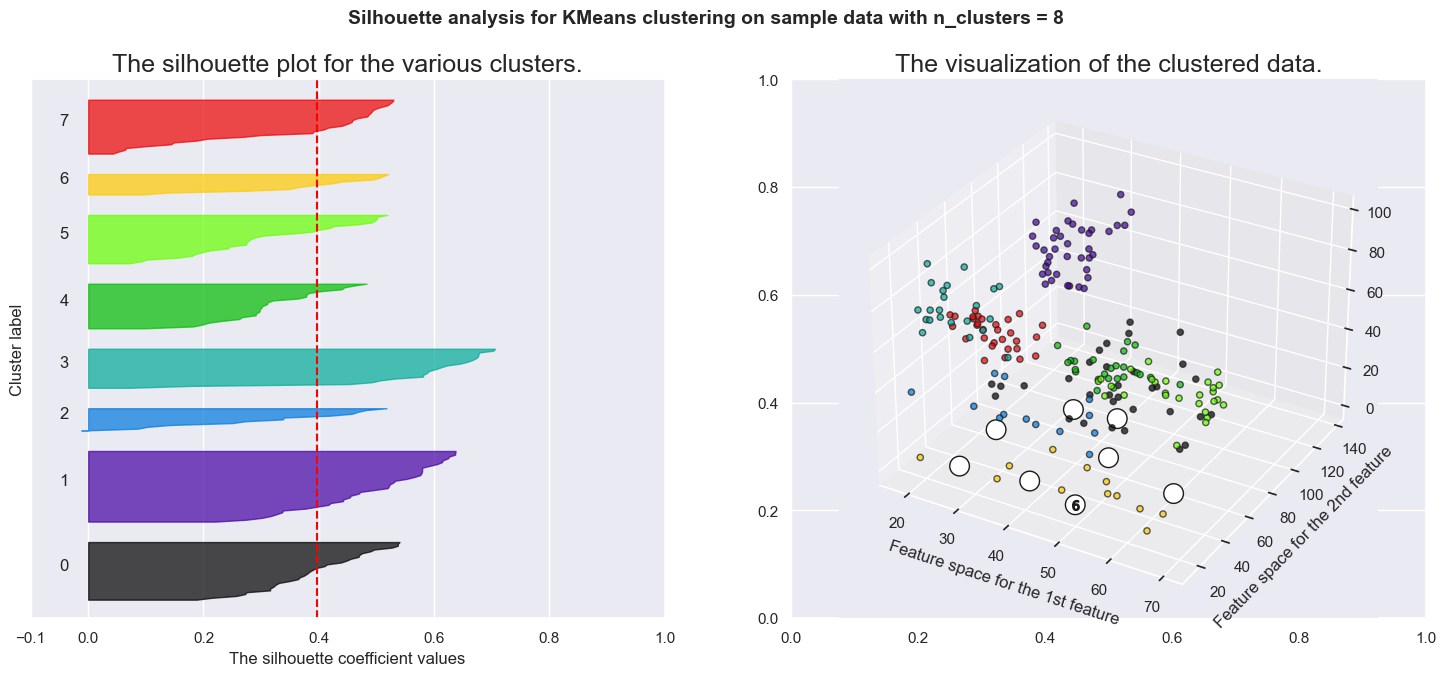

In [35]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, df_numeric.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(df_numeric)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_numeric, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_numeric, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    # Import the mplot3d toolkit

    # Create a new 3D axes using the projection="3d" parameter
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")

    # Use the scatter3D method from the Axes3D object
    ax2.scatter3D(
        df_numeric["Age"],
        df_numeric["Annual Income (k$)"],
        df_numeric["Spending Score (1-100)"],
        c=colors,
        cmap="nipy_spectral",
        alpha=0.7,
        edgecolor="k",
    )

    #ax2.scatter(
    #    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    #)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [37]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
